In [153]:
# Adding autoreload will let you edit your package and see the changes without restarting the notebook.
%load_ext autoreload
%autoreload 2

#imports
import sys
import pandas as pd
import matplotlib.pyplot as plt

#add main path to project paths
sys.path.insert(1, '../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
product_price_df = pd.read_json('../data/raw/sessions.jsonl', lines=True)
product_price_df = product_price_df[['session_id', 'event_type', 'product_id']]
product_price_df

session_id    event_type  product_id
0             124  VIEW_PRODUCT        1318
1             124   ADD_TO_CART        1318
2             124   BUY_PRODUCT        1318
3             125  VIEW_PRODUCT        1005
4             125  VIEW_PRODUCT        1009
...           ...           ...         ...
52103        9853  VIEW_PRODUCT        1073
52104        9853   ADD_TO_CART        1073
52105        9853   BUY_PRODUCT        1073
52106        9853   BUY_PRODUCT        1074
52107        9853   BUY_PRODUCT        1072

[52108 rows x 3 columns]

In [164]:
def get_category(x):
	return x.split(";")[0]

In [165]:
products_df = pd.read_json('../data/raw/products.jsonl', lines=True)
products_df = products_df[['product_id', 'price', 'category_path']]
products_df['category_path'] = products_df['category_path'].apply(get_category)
products_df = products_df.set_index('product_id')
products_df

price         category_path
product_id                               
1001          58.97  Telefony i akcesoria
1002        2048.50             Komputery
1003        7639.00             Komputery
1004          49.99         Gry i konsole
1005          49.99         Gry i konsole
...             ...                   ...
1315          54.99  Telefony i akcesoria
1316         249.00  Telefony i akcesoria
1317        1303.96  Telefony i akcesoria
1318         553.00            Sprzęt RTV
1319          14.99  Telefony i akcesoria

[319 rows x 2 columns]

In [167]:
temp = products_df.loc[product_price_df['product_id']]['price']
temp = temp.reset_index()
product_price_df['price'] = temp['price']
temp = products_df.loc[product_price_df['product_id']]['category_path']
temp = temp.reset_index()
product_price_df['category_path'] = temp['category_path']
product_price_df

session_id    event_type  product_id   price         category_path
0             124  VIEW_PRODUCT        1318  553.00            Sprzęt RTV
1             124   ADD_TO_CART        1318  553.00            Sprzęt RTV
2             124   BUY_PRODUCT        1318  553.00            Sprzęt RTV
3             125  VIEW_PRODUCT        1005   49.99         Gry i konsole
4             125  VIEW_PRODUCT        1009   69.00         Gry i konsole
...           ...           ...         ...     ...                   ...
52103        9853  VIEW_PRODUCT        1073  129.00  Telefony i akcesoria
52104        9853   ADD_TO_CART        1073  129.00  Telefony i akcesoria
52105        9853   BUY_PRODUCT        1073  129.00  Telefony i akcesoria
52106        9853   BUY_PRODUCT        1074   86.28  Telefony i akcesoria
52107        9853   BUY_PRODUCT        1072  299.00  Telefony i akcesoria

[52108 rows x 5 columns]

In [168]:
filter = product_price_df['event_type'] == "BUY_PRODUCT" 
product_price_df['product_bought'] = product_price_df[filter]['event_type']
filter = product_price_df['event_type'] == "VIEW_PRODUCT" 
product_price_df['product_viewd'] = product_price_df[filter]['event_type']
product_price_df = product_price_df.drop(columns=['event_type'])
product_price_df = product_price_df.groupby(['session_id', 'product_id']).aggregate({'session_id': 'first', 'product_id' : 'first', 'product_bought': 'first', 'product_viewd': 'first', 'price': 'first', 'category_path': 'first'})
filter = product_price_df['product_viewd'].notna() | product_price_df['product_bought'].notna()
product_price_df = product_price_df[filter]
product_price_df['product_bought'] = product_price_df['product_bought'] == 'BUY_PRODUCT'
product_price_df

session_id  product_id  product_bought product_viewd  \
session_id product_id                                                         
124        1318               124        1318            True  VIEW_PRODUCT   
125        1004               125        1004           False  VIEW_PRODUCT   
           1005               125        1005           False  VIEW_PRODUCT   
           1007               125        1007           False  VIEW_PRODUCT   
           1009               125        1009           False  VIEW_PRODUCT   
...                           ...         ...             ...           ...   
9852       1276              9852        1276           False  VIEW_PRODUCT   
           1277              9852        1277           False  VIEW_PRODUCT   
9853       1072              9853        1072            True  VIEW_PRODUCT   
           1073              9853        1073            True  VIEW_PRODUCT   
           1074              9853        1074            True  VIEW_PRODUCT   

                         price         category_path  
session_id product_id                                 
124        1318         553.00            Sprzęt RTV  
125        1004          49.99         Gry i konsole  
           1005          49.99         Gry i konsole  
           1007          89.99         Gry i konsole  
           1009          69.00         Gry i konsole  
...                        ...                   ...  
9852       1276        1816.97             Komputery  
           1277        2317.02             Komputery  
9853       1072         299.00  Telefony i akcesoria  
           1073         129.00  Telefony i akcesoria  
           1074          86.28  Telefony i akcesoria  

[30252 rows x 6 columns]

Prawdopodobieństwo kupna w zależności od ceny. Zbadane zostały 4 przedzialy: 
1. od 0 do 100
2. od 100 do 200
3. od 200 do 1000
4. powyżej 1000

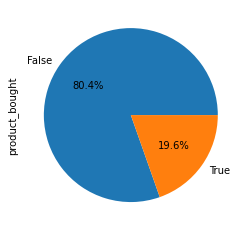

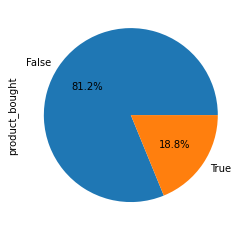

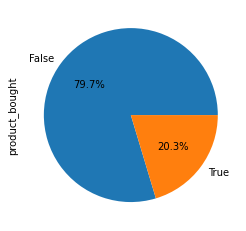

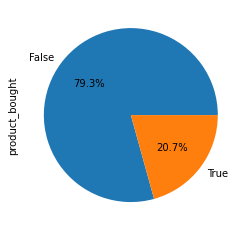

In [169]:
price_bracket1 = (product_price_df['price'] < 100) | (product_price_df['price'] == 100)
price_bracket2 = (product_price_df['price'] > 100) & ((product_price_df['price'] < 200) | (product_price_df['price'] == 200))
price_bracket3 = product_price_df['price'] > 200 & ((product_price_df['price'] < 1000) | (product_price_df['price'] == 1000))
price_bracket4 = product_price_df['price'] > 1000

for bracket in [price_bracket1, price_bracket2, price_bracket3, price_bracket4]:
    plt.figure().set_facecolor('white')
    product_price_df[bracket]['product_bought'].value_counts().plot.pie(autopct=lambda x: str(round(x, 1)) + "%")
    product_price_df[bracket]['product_bought'].value_counts()

Prawdopodobieństwo kupna w zależności od kategorii. Kategorie w kolejności: 'Sprzęt RTV' 'Gry i konsole' 'Komputery' 'Telefony i akcesoria'

['Sprzęt RTV' 'Gry i konsole' 'Komputery' 'Telefony i akcesoria']


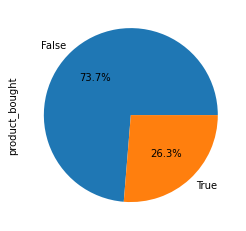

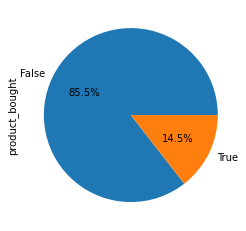

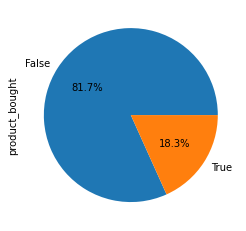

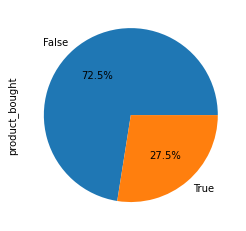

In [171]:
for category in product_price_df['category_path'].unique():
    filter = product_price_df['category_path'] == category
    plt.figure().set_facecolor('white')
    product_price_df[filter]['product_bought'].value_counts().plot.pie(autopct=lambda x: str(round(x, 1)) + "%")
    product_price_df[filter]['product_bought'].value_counts()

print(product_price_df['category_path'].unique())